# **1.) Importing libraries**

In [22]:
# Own functions.
import myfunctions
# General.
import pandas as pd
import numpy as np
import time
import re
import pickle
import json
# Pipelining.
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# Vectorizing and preprocessing.
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Grid Search.
from sklearn.model_selection import GridSearchCV
# Crawling tweets.
import GetOldTweets3 as got
import tweepy
# Plotting.
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
# Classifying.
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# Evaluating.
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

# **2.) Reading, preparing Sentiment140 data. Performing descriptive analysis.**

In [299]:
# Reading Sentiment140 dataset.
origin_df = pd.read_csv(filepath_or_buffer = "training.1600000.processed.noemoticon.csv", 
                        header = None,
                        index_col = False,
                        names = ["sentiment", "id", "date_time", "query", "account", "text"],
                        encoding = 'latin-1')

# Extracting columns. Changing type of date column.
origin_df = origin_df.iloc[:, [0, 2, 5]]
origin_df["date_time"] = pd.to_datetime(origin_df["date_time"])

# Removing usernames and links from tweets.
for i in origin_df.index:
    origin_df.at[i, 'text'] = re.sub(r"(?:\@|https?\://)\S+", "", origin_df.at[i, 'text'])
origin_df.to_csv("datasets/sentiment140/sentiment140_final.csv", index = False)

# Comparing how number of features has changed.
origin_df = pd.read_csv("datasets/sentiment140/sentiment140_prepared.csv")
X_origin = CountVectorizer().fit_transform(origin_df["text"])
print(X_origin.shape)

names_links_removed_df = pd.read_csv("datasets/sentiment140/sentiment140_final.csv")
X_names_links_removed = CountVectorizer().fit_transform(names_links_removed_df["text"])
print(X_names_links_removed.shape)

(1600000, 684358)
(1600000, 287922)


In [300]:
# Extracting training, "tuning" and test set.
train_df, test_df, tuning_df = myfunctions.read_split_data(
    path = "datasets/sentiment140/sentiment140_final.csv", 
    tuning_set = 0.1, 
    print_n = True)

Number of tweets in origin data in total: 1600000
Number of tweets in origin data with sentiment == 1 (positive): 800000
Number of tweets in origin data with sentiment == 0 (negative): 800000

Number of tweets in training data in total: 1120000
Number of tweets in training data with sentiment == 1 (positive): 560000
Number of tweets in training data with sentiment == 0 (negative): 560000

Number of tweets in test data in total: 480000
Number of tweets in test data with sentiment == 1 (positive): 240000
Number of tweets in test data with sentiment == 0 (negative): 240000

Number of tweets in tuning data in total: 112000
Number of tweets in tuning data with sentiment == 1 (positive): 56000
Number of tweets in tuning data with sentiment == 0 (negative): 56000


# 3.) Finding best pipeline by tuning vectorizer, preprocessor function and model hyperparameters for each model.

In [8]:
# Loading model. Disabling loading non-necessary model components.
nlp = spacy.load("en_core_web_sm", disable = ["tagger", "parser", "ner", "textcat"])

# Defining preprocess functions.
def preprocess_1(text):
    return [t.lemma_ for t in nlp(text)]
def preprocess_2(text):
    return [t.lemma_ for t in nlp(text) if t.is_stop]
def preprocess_3(text):
    return [t.lemma_ for t in nlp(text) if t.lemma_.isalpha()]
def preprocess_4(text):
    return [t.lemma_ for t in nlp(text) if t.lemma_.isalpha() and not t.is_stop]

**3.1) Naive Bayes**

3.1.1) Calculating evlauation metrics for defined combinations using GridSearch with CV.

In [ ]:
myfunctions.vect_model_tuning(train_set = tuning_df, 
                  model = MultinomialNB, 
                  vectorizers = [CountVectorizer, TfidfVectorizer],
                  preprocessors = [None, preprocess_1, preprocess_2, preprocess_3, preprocess_4],
                  params_dict = {"clf__alpha": (0, 1, 2, 3)},
                  file_name = "nb", 
                  njobs = -1)

*3.1.2) Evaluating visually.*

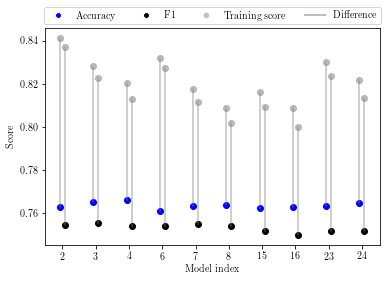

In [3]:
# Reading data.
nb_tuning_results = pd.read_csv("vect_model_tuning/nb.csv")
myfunctions.visual_model_comparison(metric_list = ["accuracy", "f1"], 
                                    gs_res = nb_tuning_results, 
                                    directory = "vect_model_tuning",
                                    plot_name = "nb",
                                    top_n = 10)

**3.2) Decision Tree.**

3.2.1) Calculating evlauation metrics for defined combinations using GridSearch with CV.

In [ ]:
myfunctions.vect_model_tuning(train_set = tuning_df, 
                              model = DecisionTreeClassifier, 
                              vectorizers = [CountVectorizer, TfidfVectorizer],
                              preprocessors = [None,preprocess_1, preprocess_3, preprocess_4], #preprocess_2
                              params_dict = {"clf__criterion": ("gini", "entropy"),
                                             "clf__max_depth": (45, 50, 55)},
                              file_name = "tree", 
                              njobs = 1)

*3.2.2) Evaluating visually.*

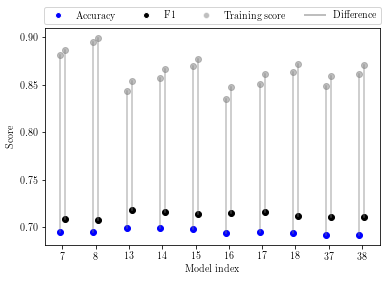

In [4]:
# Reading data.
tree_tuning_results = pd.read_csv("vect_model_tuning/tree.csv")
myfunctions.visual_model_comparison(metric_list = ["accuracy", "f1"], 
                                    gs_res = tree_tuning_results, 
                                    directory = "vect_model_tuning",
                                    plot_name = "tree",
                                    top_n = 10)

**3.3) XGBoost.**

3.3.1) Calculating evlauation metrics for defined combinations using GridSearch with CV.

In [ ]:
myfunctions.vect_model_tuning(train_set = tuning_df, 
                              model = XGBClassifier, 
                              vectorizers = [CountVectorizer, TfidfVectorizer],
                              preprocessors = [None, preprocess_1, preprocess_3, preprocess_4], #preprocess_2
                              params_dict = {"clf__eta": (0.1, 0.3),
                                             "clf__max_depth": (6, 8)},
                              file_name = "xgb", 
                              njobs = 1)

*3.3.2) Evaluating visually.*

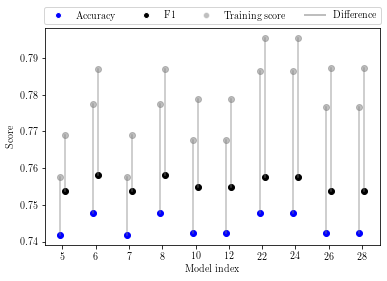

In [5]:
# Reading data.
xgb_tuning_results = pd.read_csv("vect_model_tuning/xgb.csv")
myfunctions.visual_model_comparison(metric_list = ["accuracy", "f1"], 
                                    gs_res = xgb_tuning_results, 
                                    directory = "vect_model_tuning",
                                    plot_name = "xgb",
                                    top_n = 10)

# **4.) Fitting best identified classifiers (3 in total) on whole training set. Classifying on whole test set. Deciding for one.**

**4.1) Fitting classifiers. Evaluating.**

In [ ]:
# Initializing pipelines for three best identified classifiers.
nb_pipeline = make_pipeline(CountVectorizer(tokenizer = preprocess_1), MultinomialNB(alpha = 3))
tree_pipeline = make_pipeline(CountVectorizer(tokenizer = preprocess_3),
                              DecisionTreeClassifier(criterion = "gini", max_depth = 45))
xgb_pipeline = make_pipeline(CountVectorizer(tokenizer = preprocess_3),
                             XGBClassifier(eta = 0.3, max_depth = 8))

# Defining dictionary with pipelines and corresponding classifier names.
classifier_pipelines = {"nb": ["Naive Bayes", nb_pipeline],
                        "tree": ["Decision Tree", tree_pipeline],
                        "xgb": ["XGBoost", xgb_pipeline]}

# Fitting and evaluating all classifiers on entire training / test set.
myfunctions.fit_best_classifiers(classifier_pipelines, train_df, test_df)

**4.2) Visual inspection of results.**

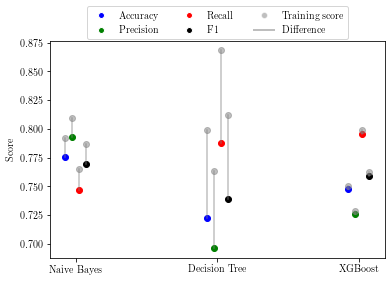

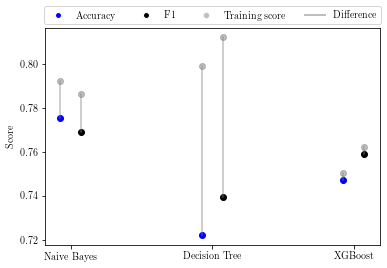

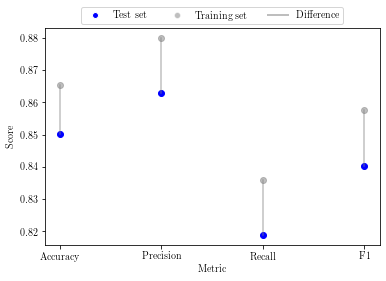

In [6]:
file_class = pd.read_csv("best_classifiers/results_classes.csv")
file_probs = pd.read_csv("best_classifiers/results_probs.csv")

# Comparing differenct classifiers.

myfunctions.visual_model_comparison(metric_list = ["accuracy", "precision", "recall", "f1"], 
                                    gs_res = file_class, 
                                    directory = "best_classifiers",
                                    plot_name = "plot_classes",
                                    x_label = "")

myfunctions.visual_model_comparison(metric_list = ["accuracy", "f1"], 
                                    gs_res = file_class, 
                                    directory = "best_classifiers",
                                    plot_name = "plot_classes_short",
                                    x_label = "")

# Single visual inspection of Naive Bayes classifier using "75%-approach".

## Subsetting data.
file_probs_nb = file_probs.loc[file_probs["model_idx"] == "Naive Bayes"]

## Plotting test and training scores.
plt.plot("Accuracy", file_probs_nb["mean_val_accuracy"], marker = "o", color = "blue")
plt.plot("Accuracy", file_probs_nb["mean_train_accuracy"], marker = "o", color = "grey", alpha = 0.5)
plt.plot("Precision", file_probs_nb["mean_val_precision"], marker = "o", color = "blue")
plt.plot("Precision", file_probs_nb["mean_train_precision"], marker = "o", color = "grey", alpha = 0.5)
plt.plot("Recall", file_probs_nb["mean_val_recall"], marker = "o", color = "blue")
plt.plot("Recall", file_probs_nb["mean_train_recall"], marker = "o", color = "grey", alpha = 0.5)
plt.plot("F1", file_probs_nb["mean_val_f1"], marker = "o", color = "blue")
plt.plot("F1", file_probs_nb["mean_train_f1"], marker = "o", color = "grey", alpha = 0.5)

## Plotting difference between scores as line.
axes = plt.gca()
ylim = axes.get_ylim()
ylim_range = ylim[1] - ylim[0]
for metric in ["accuracy", "precision", "recall", "f1"]:
    val_name = "mean_val_" + metric
    val_metric = float(file_probs_nb[val_name])
    train_name = "mean_train_" + metric
    train_metric = float(file_probs_nb[train_name])
    if val_metric <= train_metric:
        vline_min = 1 - (ylim[1] - val_metric) / ylim_range
        vline_max = 1 - (ylim[1] - train_metric) / ylim_range
    else:
        vline_min = 1 - (ylim[1] - train_metric) / ylim_range
        vline_max = 1 - (ylim[1] - val_metric) / ylim_range
    plt.axvline(metric.capitalize(), ymin = vline_min, ymax = vline_max, color = "grey", alpha = 0.5)
    
## Adding legend and labels.
legend_elements = [Line2D([0], [0], marker = 'o', color = "w",
                          markerfacecolor = "blue", label = "Test set"),
                   Line2D([0], [0], marker = 'o', color = "w", alpha = 0.5,
                          markerfacecolor = "grey", label = "Training set"),
                   Line2D([0], [0], color = "grey", alpha = 0.5, lw = 2, label = "Difference")]               
plt.legend(handles = legend_elements, loc = "upper center", ncol = 3,
           bbox_to_anchor=(0.5, 1.12), fancybox = True, shadow = False)
plt.xlabel("Metric")
plt.ylabel("Score")

## Saving plot.
plt.savefig("best_classifiers/plot_probs_nb.png", dpi = 500)

**4.3) Loading best classifier.**

Naive Bayes was previously stored as the best classifier (not shown here anymore).

In [10]:
best_classifier = pickle.load(open("best_classifiers/best_Naive Bayes_classifier.sav", "rb"))

# **5.) Crawling and preparing self-crawled tweets.**

**5.0.1) Crawling Tweepy tweets.**

In [ ]:
import tweepy
import pandas as pd
import json # The API returns JSON formatted text

access_token  = "1195001286401376257-XOE3KgkjwAH0Zz5WshgTh0H361P82a"
access_token_secret  = "ksBLfi4tsyaHrFrtQoQrHmTg8MQbTAAXS0uUDtuxTLOlX"
consumer_key  = "jYPvtE9lORvpeqEbWlczWj9d4"
consumer_secret  = "htkEyKbOI0D7SxtkKI2rSN3cVJIpx81k3N3Axe5Jo8DAhVCKq3"

# Pass OAuth details to tweepy's OAuth handler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# SEARCH PARAMETER
OUTPUT_FILE = "twitter_api_results10.txt"
FINAL_OUTPUT_CSV = "Africa_South_15_12_4.csv"
LOCATIONS = -18.457031,-36.644918,53.437500,12.153904
# LOCATIONS = -13.683,48.5,3.858,64.067 UK
COUNTRY = "Africa South"
TWEETS_TO_CAPTURE = 5000

class MyStreamListener(tweepy.StreamListener):
    """
    Twitter listener, collects streaming tweets and output to a file
    """
    def __init__(self, api=None):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open(OUTPUT_FILE, "w")

    def on_status(self, status):
        tweet = status._json
        self.file.write(json.dumps(tweet) + '\n' )
        self.num_tweets += 1
        
        # Stops streaming when it reaches the limit
        if self.num_tweets <= TWEETS_TO_CAPTURE:
            if self.num_tweets % 50 == 0: # just to see some progress...
                print('Numer of tweets captured so far: {}'.format(self.num_tweets))
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print(status)

# Initialize Stream listener. Make sure to pay attention to API limit. 
l = MyStreamListener(api = tweepy.API(wait_on_rate_limit=True))

# Create you Stream object with authentication
stream = tweepy.Stream(auth, l)

# Filter Twitter Streams to capture data by the keywords:
stream.filter(locations = LOCATIONS)

# Initialize empty list to store tweets
tweets_data = []

# Open connection to file
with open(OUTPUT_FILE, "r") as tweets_file:
    # Read in tweets and store in list
    for line in tweets_file:
        tweet = json.loads(line)
        tweets_data.append(tweet)

# Initialize empty df.
df = pd.DataFrame(columns=['date_time', "country", 'tweet'])

# Store only desired information within df.
for tweet_no in range(0, len(tweets_data)):
    
    # Filtering out non-english-tweets.
    if tweets_data[tweet_no]["lang"] == "en":
        
        # If tweets are long, they are shortenend in "text" and stored in "extended_tweet".
        if "extended_tweet" in tweets_data[tweet_no].keys():
            df = df.append(pd.DataFrame({"date_time": [tweets_data[tweet_no]["created_at"]],
                                         "country": COUNTRY,
                                         "tweet": [tweets_data[tweet_no]["extended_tweet"]["full_text"]]}))
        else:
            df = df.append(pd.DataFrame({"date_time": [tweets_data[tweet_no]["created_at"]],
                                         "country": COUNTRY,
                                         "tweet": [tweets_data[tweet_no]["text"]]}))

# Adjust date-time-variable.
df['date_time'] = pd.to_datetime(df["date_time"])

# Write as csv.
df.to_csv(FINAL_OUTPUT_CSV, index = False)

**5.0.2) Crawling GetOldTweets3 tweets.**

In [ ]:
i = 0

circles = [#("UK", "54.673831, -7.294922", "651km"), # UK
           ("Africa_South", "-15.001388342381775, 37.675766944885254", "3139km"), # africa1
           ("Africa_South", "-3.3964456609936056,-0.2050924301147461", "1852km"), # africa2
           ("Africa_South", "2.110518253704713, 16.24735135781657", "1247km")] # africa3

time_ranges = [("2015-01-01", "2015-12-31"),
               ("2016-01-01", "2016-12-31"),
               ("2017-01-01", "2017-12-31"),
               ("2018-01-01", "2018-12-31"),
               ("2019-01-01", "2019-12-31")]

# Initializing empty dataframe.
all_tweets = pd.DataFrame(columns=["country", "year", "tweet"])

for circle in circles:
    country = circle[0]
    print("country:" + str(country))
    coordinates = circle[1]
    radius = circle[2]
    if country == "UK":
        n_tweets = 40000
    elif country == "Africa_South":
        if radius == "3139km": # africa1
            n_tweets = 28000
        elif radius == "1852km":  # africa2
            n_tweets = 8000
        else:  # africa3
            n_tweets = 4000
        
        # The chosen number of tweets for the African region is aimed to be proportional to the size of the region.
        
    for time_range in time_ranges:
        start_date = time_range[0]
        end_date = time_range[1]
        print("year:" + start_date[:4])
        before_crawling = time.time()
        tweetCriteria = got.manager.TweetCriteria().setMaxTweets(n_tweets).setSince(start_date).setUntil(end_date).setNear(coordinates).setWithin(radius).setLang("en")
        tweets = got.manager.TweetManager.getTweets(tweetCriteria)
        print("Crawling done. Taken time: " + str(time.time() - before_crawling))
        print(len(tweets))
        for tweet in tweets:
            all_tweets.loc[i] = [country, start_date[:4], tweet.text]
            i = i+1
        
        all_tweets.to_csv("tweets_by_year_africa.csv", index = False)

**5.1) Reading Tweepy data.**

In [303]:
uk1 = pd.read_csv("datasets/own_tweets/UK_15_11.csv")
uk2 = pd.read_csv("datasets/own_tweets/UK_15_11_2.csv")
uk3 = pd.read_csv("datasets/own_tweets/UK_15_12.csv")
uk4 = pd.read_csv("datasets/own_tweets/UK_15_12_2.csv")
uk5 = pd.read_csv("datasets/own_tweets/UK_15_12_3.csv")
uk_df = uk1.append(uk2, ignore_index=True)
uk_df = uk_df.append(uk3, ignore_index = True)
uk_df = uk_df.append(uk4, ignore_index = True)
uk_df = uk_df.append(uk5, ignore_index = True)
africa1 = pd.read_csv("datasets/own_tweets/Africa_South_15_11.csv")
africa2 = pd.read_csv("datasets/own_tweets/Africa_South_19_11.csv")
africa3 = pd.read_csv("datasets/own_tweets/Africa_South_15_12.csv")
africa4 = pd.read_csv("datasets/own_tweets/Africa_South_15_12_2.csv")
africa5 = pd.read_csv("datasets/own_tweets/Africa_South_15_12_3.csv")
africa6 = pd.read_csv("datasets/own_tweets/Africa_South_15_12_4.csv")
africa_df = africa1.append(africa2, ignore_index=True)
africa_df = africa_df.append(africa3, ignore_index=True)
africa_df = africa_df.append(africa4, ignore_index=True)
africa_df = africa_df.append(africa5, ignore_index=True)
africa_df = africa_df.append(africa6, ignore_index=True)
print(len(uk_df.tweet))
print(len(africa_df))

102158
102349


**5.2) Modidying Tweepy data.**

In [304]:
# Removing four weird tweet collections for africa_df.
africa_df = africa_df[~africa_df["date_time"].str[:7].isin(['Forgett', 'FRIDAYS', 'playhil', 'who wil'])]

# Removing usernames and links.
for i in africa_df.index:
    africa_df.at[i, 'tweet'] = re.sub(r"(?:\@|https?\://)\S+", "", africa_df.at[i, 'tweet'])
for i in uk_df.index:
    uk_df.at[i, 'tweet'] = re.sub(r"(?:\@|https?\://)\S+", "", uk_df.at[i, 'tweet'])

# Removing emojis (as in provided origin_df).
for i in africa_df.index:
    africa_df.at[i, 'tweet'] = africa_df.at[i, 'tweet'].encode('ascii', 'ignore').decode('ascii')
for i in uk_df.index:
    uk_df.at[i, 'tweet'] = uk_df.at[i, 'tweet'].encode('ascii', 'ignore').decode('ascii')

**5.3) Describing Tweepy data.**

In [306]:
# Proving that tweets are not used for training.
print(africa_df["date_time"].str[:10].unique()) # array(['2019-11-15', '2019-11-19'], dtype=object)
print(uk_df["date_time"].str[:10].unique()) # array(['2019-11-14', '2019-11-15'], dtype=object)
print(origin_df["date_time"].str[:7].unique()) # array(['2009-04', '2009-05', '2009-06'], dtype=object)

# Comparing vocabulary sizes of both dataframes. Size-wise pretty equal.
uk_X = CountVectorizer().fit_transform(uk_df["tweet"])
print(uk_X.shape)
africa_X = CountVectorizer().fit_transform(africa_df["tweet"])
print(africa_X.shape)

['2019-11-15' '2019-11-19' '2019-12-15']
['2019-11-14' '2019-11-15' '2019-12-15']
['2009-04' '2009-05' '2009-06']
(102158, 72019)
(102345, 62743)


# 6.) Classifying self-crawled tweets.

**6.1) Performing classification on Tweepy tweets.**

In [ ]:
uk_prediction = myfunctions.classify_new_tweets(new_tweets_df = uk_df, 
                                                classifier = best_classifier)

africa_prediction = myfunctions.classify_new_tweets(new_tweets_df = africa_df, 
                                                    classifier = best_classifier)

**6.2) Analyzing general distribution for Tweepy tweets.**

In [309]:
uk_pos = uk_prediction.loc[uk_prediction["classification"] == "pos"]
uk_neg = uk_prediction.loc[uk_prediction["classification"] == "neg"]

africa_pos = africa_prediction.loc[africa_prediction["classification"] == "pos"]
africa_neg = africa_prediction.loc[africa_prediction["classification"] == "neg"]

# Calculating number of considered tweets.
print("total tweets considered (UK, origin): " + str(len(uk_pos) + len(uk_neg)))
print("total tweets considered (Africa, origin): " + str(len(africa_pos) + len(africa_neg)))

# Downsampling number of considered tweets to 50,000 for both regions (by random!).
uk_prediction_sample = uk_prediction.sample(n = 50000)
uk_sample_pos = uk_prediction_sample.loc[uk_prediction_sample["classification"] == "pos"]
uk_sample_neg = uk_prediction_sample.loc[uk_prediction_sample["classification"] == "neg"]

print("\ntotal tweets considered (UK, sample): " + str(len(uk_sample_pos) + len(uk_sample_neg)))
print("% positive tweets (UK, sample): " + str(len(uk_sample_pos)/(len(uk_sample_neg) + len(uk_sample_pos))))
print("% negative tweets (UK, sample): " + str(len(uk_sample_neg)/(len(uk_sample_neg) + len(uk_sample_pos))))

africa_prediction_sample = africa_prediction.sample(n = 50000)
africa_sample_pos = africa_prediction_sample.loc[africa_prediction_sample["classification"] == "pos"]
africa_sample_neg = africa_prediction_sample.loc[africa_prediction_sample["classification"] == "neg"]

print("\ntotal tweets considered (Africa, sample): " + str(len(africa_sample_pos) + len(africa_sample_neg)))
print("% positive tweets (Africa, sample): " + str(len(africa_sample_pos)/(len(africa_sample_neg) + len(africa_sample_pos))))
print("% negative tweets (Africa, sample): " + str(len(africa_sample_neg)/(len(africa_sample_neg) + len(africa_sample_pos))))

total tweets considered (UK, origin): 60579
total tweets considered (Africa, origin): 50449

total tweets considered (UK, sample): 50000
% positive tweets (UK, sample): 0.66148
% negative tweets (UK, sample): 0.33852

total tweets considered (Africa, sample): 50000
% positive tweets (Africa, sample): 0.62608
% negative tweets (Africa, sample): 0.37392


**6.3) Further analyzing sentiments by category within Tweepy tweets.**

In [ ]:
# Deriving entity type for each tweet using spacy.
nlp = spacy.load("en_core_web_sm")
def get_entities(df_tweets):
    ents_list = [] 
    for index, row in df_tweets.iterrows():
        doc = nlp(row["tweet"])
        for ent in doc.ents:
            ents_list.append(ent.label_)
    return ents_list

ents_uk_pos = get_entities(uk_sample_pos)
pickle.dump(ents_uk_pos, open("entities/uk_pos.sav", 'wb'))
 
ents_uk_neg = get_entities(uk_sample_neg)
pickle.dump(ents_uk_neg, open("entities/uk_neg.sav", 'wb'))

ents_africa_pos = get_entities(africa_sample_pos)
pickle.dump(ents_africa_pos, open("entities/africa_pos.sav", 'wb'))
 
ents_africa_neg = get_entities(africa_sample_neg)
pickle.dump(ents_africa_neg, open("entities/africa_neg.sav", 'wb'))

In [2]:
# Counting entity types for UK and Africa. Storing results in seperated dataframes.
from collections import Counter
ents_uk_pos = pickle.load(open("entities/uk_pos.sav", "rb"))
ents_uk_pos = pd.DataFrame.from_dict(Counter(ents_uk_pos), orient='index').reset_index()
ents_uk_neg = pickle.load(open("entities/uk_neg.sav", "rb"))
ents_uk_neg = pd.DataFrame.from_dict(Counter(ents_uk_neg), orient='index').reset_index()
ents_africa_pos = pickle.load(open("entities/africa_pos.sav", "rb"))
ents_africa_pos = pd.DataFrame.from_dict(Counter(ents_africa_pos), orient='index').reset_index()
ents_africa_neg = pickle.load(open("entities/africa_neg.sav", "rb"))
ents_africa_neg = pd.DataFrame.from_dict(Counter(ents_africa_neg), orient='index').reset_index()

In [3]:
# Merging seperated dataframes. Calculating relative proportion of each entity type.
ents_all = ents_uk_pos.merge(
    right = ents_uk_neg, how = "outer", on = "index").merge(
    right = ents_africa_pos, how = "outer", on = "index").merge(
    right = ents_africa_neg, how = "outer", on = "index")
ents_all.columns = ["entity", "uk_pos", "uk_neg", "africa_pos", "africa_neg"]
ents_all = ents_all.sort_values(by = "entity")
ents_all["uk_pos"] = ents_all["uk_pos"] / sum(ents_all["uk_pos"])
ents_all["uk_neg"] = ents_all["uk_neg"] / sum(ents_all["uk_neg"])
ents_all["africa_pos"] = ents_all["africa_pos"] / sum(ents_all["africa_pos"])
ents_all["africa_neg"] = ents_all["africa_neg"] / sum(ents_all["africa_neg"])
ents_all.iloc[17, 0] = "WORK OF ART"

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


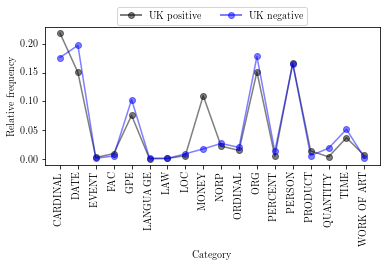

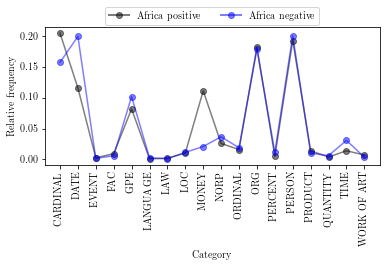

In [5]:
# Plotting results.

# Defining font.
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.subplots_adjust(bottom = 0.4)
plt.plot(ents_all["entity"], ents_all["uk_pos"], marker = "o", color = "black", alpha = 0.5)
plt.plot(ents_all["entity"], ents_all["uk_neg"], marker = "o", color = "blue", alpha = 0.5)
plt.xticks(rotation = "vertical")
legend_elements = [Line2D([0], [0], marker = "o" , color = "black", alpha = 0.5, lw = 2, label = "UK positive"),
                   Line2D([0], [0], marker = "o", color = "blue", alpha = 0.5, lw = 2, label = "UK negative")]
plt.legend(handles = legend_elements, loc = "upper center", ncol = 2,  
           bbox_to_anchor=(0.5, 1.18), fancybox = True, shadow = False)
plt.xlabel("Category")
plt.ylabel("Relative frequency")
plt.savefig("entities/uk.png", dpi = 500)
plt.show()

plt.subplots_adjust(bottom = 0.4)
plt.plot(ents_all["entity"], ents_all["africa_pos"], marker = "o", color = "black", alpha = 0.5)
plt.plot(ents_all["entity"], ents_all["africa_neg"], marker = "o", color = "blue", alpha = 0.5)
plt.xticks(rotation = "vertical")
legend_elements = [Line2D([0], [0], marker = "o" , color = "black", alpha = 0.5, lw = 2, label = "Africa positive"),
                   Line2D([0], [0], marker = "o", color = "blue", alpha = 0.5, lw = 2, label = "Africa negative")]
plt.legend(handles = legend_elements, loc = "upper center", ncol = 2,  
           bbox_to_anchor=(0.5, 1.18), fancybox = True, shadow = False)
plt.xlabel("Category")
plt.ylabel("Relative frequency")
plt.savefig("entities/africa.png", dpi = 500)
plt.show()

**6.4) Analyzing tweets over time using GetOldTweets3.**

In [11]:
# Reading data.
by_year_1 = pd.read_csv("datasets/own_tweets/tweets_by_year.csv")
by_year_2 = pd.read_csv("datasets/own_tweets/tweets_by_year2.csv")
by_year = by_year_1.append(by_year_2, ignore_index=True)

# Dropping one case where tweet is nan.
by_year = by_year.dropna()

# Removing usernames and links.
for i in by_year.index:
    by_year.at[i, 'tweet'] = re.sub(r"(?:\@|https?\://)\S+", "", by_year.at[i, 'tweet'])
    
# Removing emojis (as in provided origin_df).
for i in by_year.index:
    by_year.at[i, 'tweet'] = by_year.at[i, 'tweet'].encode('ascii', 'ignore').decode('ascii')

In [12]:
by_year.groupby(["country", "year"]).size()

country       year
Africa_South  2015    37000
              2016    10696
              2017    37000
              2018    14024
              2019    37000
UK            2015    40000
              2016    40000
              2017    40000
              2018    40000
              2019    39999
dtype: int64

In [14]:
# Classifying tweets.
by_year_preds = myfunctions.classify_new_tweets(new_tweets_df = by_year, 
                                    classifier = best_classifier)

In [15]:
# Analyzing predicted tweets per region and year.
by_year_preds.groupby(["country", "year"]).size()
# Need to downsampling to 5847 for comparison between country and year! That's enough, higher sample
# sizes (e.g. by excluding 2016 and 2018) show similar results.

country       year
Africa_South  2015    21024
              2016     5847
              2017    25463
              2018    10722
              2019    17051
UK            2015    24661
              2016    26997
              2017    27063
              2018    29781
              2019    22347
dtype: int64

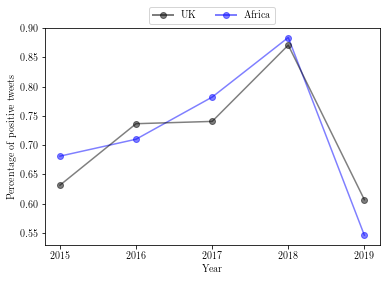

In [23]:
# Downsampling data. 
by_year_preds = by_year_preds.sample(frac = 1)
by_year_preds_subset = pd.DataFrame(columns=["country", "year", "tweet", "prob_pos", "classification"])
for country in ["UK", "Africa_South"]:
    for year in [2015, 2016, 2017, 2018, 2019]:
        country_year_subset = by_year_preds.loc[by_year_preds["country"] == country]
        country_year_subset = country_year_subset.loc[country_year_subset["year"] == year]
        country_year_subset = country_year_subset.head(5847)
        by_year_preds_subset = by_year_preds_subset.append(country_year_subset)

# Aggregating data.
by_year_preds_subset_grouped = pd.DataFrame({'count': by_year_preds_subset.groupby(["country", "year", "classification"]).size()}).reset_index()
by_year_preds_subset_grouped["total"] = 5847
by_year_preds_subset_grouped["percentage"] = by_year_preds_subset_grouped["count"] / by_year_preds_subset_grouped["total"]
by_year_preds_subset_grouped = by_year_preds_subset_grouped.loc[by_year_preds_subset_grouped["classification"] == "pos"]

## Plotting.
myfunctions.plot_tweets_by_year(by_year_preds_subset_grouped, "comparison_country_year")